# EEG-LFP 预处理完整流程

本notebook演示从BIDS格式数据到预处理完成的完整流程。

## 流程概览
1. 数据检查与验证
2. 通用清洗（去趋势、滤波、重采样）
3. EEG预处理（坏导检测、重参考、ICA去伪迹、分段、源重建）
4. LFP预处理（刺激伪迹去除、电极管理、降噪）
5. 联合处理（时间对齐、频段分解、标准化）
6. 质量控制与保存

In [1]:
import pyprep, autoreject, mne_icalabel
print("pyprep version:", pyprep.__version__)
print("autoreject version:", autoreject.__version__)
print("mne-icalabel version:", mne_icalabel.__version__)



pyprep version: 0.5.0
autoreject version: 0.4.3
mne-icalabel version: 0.8.1


In [2]:
# 导入必要的库
import sys
sys.path.append('/workspace/src')

import numpy as np
import mne
import matplotlib.pyplot as plt
from pathlib import Path


# 导入预处理模块
from preprocessing import DataValidator, EEGCleaner, LFPCleaner,EEGPreprocessor,LFPPreprocessor,JointPreprocessor,QualityControl, BIDSDerivativesSaver

# 设置
mne.set_log_level('WARNING')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

2025-10-27 17:10:08,125 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


## 1. 数据检查与验证

In [3]:
# 设置BIDS根目录
from pathlib import Path
import os

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")

# Define paths (use relative paths)
DATA_ROOT = project_root / 'shared' / 'data' / 'raw'
RESULTS_ROOT = project_root / 'shared' / 'results'
BIDS_ROOT = project_root / 'shared' / 'data' / 'bids_dataset'

# Subject information
SUBJECT_ID = 'Wue01'
STIM_FREQ = 55  # Hz

bids_root = project_root / 'shared' / 'data' / 'bids_dataset'

data_root = bids_root / 'derivatives' / 'mne-python'
subject = 'sub-001'
session = 'ses-01'
task = 'task-StimOn55HzFull2'


# 创建验证器
validator = DataValidator(data_root)

# 运行完整验证
validation_results = validator.run_full_validation(
    subject=subject,
    session=session,
    task=task,
    validate_lfp=True
)

# 生成验证报告
report = validator.generate_validation_report()
print(report)

2025-10-27 17:10:13,598 - preprocessing.data_validation - INFO - ============================================================
2025-10-27 17:10:13,600 - preprocessing.data_validation - INFO - 开始数据验证
2025-10-27 17:10:13,603 - preprocessing.data_validation - INFO - ============================================================
2025-10-27 17:10:13,605 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)


Current working directory: /workspace


2025-10-27 17:10:15,106 - preprocessing.data_io - INFO - ✓ 已加载EEG数据: fif格式
2025-10-27 17:10:15,108 - preprocessing.data_io - INFO -   采样率: 500.0 Hz
2025-10-27 17:10:15,109 - preprocessing.data_io - INFO -   通道数: 281
2025-10-27 17:10:15,110 - preprocessing.data_io - INFO -   时长: 95.33 秒
2025-10-27 17:10:15,111 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-10-27 17:10:15,124 - preprocessing.data_io - INFO - ✓ 已加载LFP数据: fif格式
2025-10-27 17:10:15,127 - preprocessing.data_io - INFO -   采样率: 250.0 Hz
2025-10-27 17:10:15,128 - preprocessing.data_io - INFO -   通道数: 4
2025-10-27 17:10:15,129 - preprocessing.data_io - INFO -   时长: 95.23 秒
2025-10-27 17:10:15,129 - preprocessing.data_validation - WARNING - ⚠ 采样率不匹配: EEG=500.0 Hz, LFP=250.0 Hz
2025-10-27 17:10:15,130 - preprocessing.data_validation - INFO -   建议重采样至统一采样率
2025-10-27 17:10:15,131 - preprocessing.data_validation - WARNING - ⚠ 时间对齐存在问题:
2025-10-27 17:10:15,133 - preprocessing.data_validation - WARNING -   时间偏移: 0.000 ms
20

EEG-LFP 数据验证报告

1. 采样率检查
   EEG采样率: 500.0 Hz
   LFP采样率: 250.0 Hz
   状态: 不匹配

2. 时间对齐检查
   时间偏移: 0.000 ms
   时长差异: 102.000 ms
   状态: 需要对齐

3. 事件同步检查
   EEG事件: N/A
   LFP事件: N/A

4. 元数据一致性
   状态: 通过


In [4]:
# 加载数据供后续使用
eeg_raw, eeg_metadata = validator.load_eeg_data(subject, session, task)
lfp_raw, lfp_metadata = validator.load_lfp_data(subject, session, task)

print(f"\nEEG数据信息:")
print(eeg_raw.info)
print(f"\nLFP数据信息:")
print(lfp_raw.info)

2025-10-27 17:10:26,013 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-10-27 17:10:26,215 - preprocessing.data_io - INFO - ✓ 已加载EEG数据: fif格式
2025-10-27 17:10:26,216 - preprocessing.data_io - INFO -   采样率: 500.0 Hz
2025-10-27 17:10:26,217 - preprocessing.data_io - INFO -   通道数: 281
2025-10-27 17:10:26,217 - preprocessing.data_io - INFO -   时长: 95.33 秒
2025-10-27 17:10:26,218 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-10-27 17:10:26,228 - preprocessing.data_io - INFO - ✓ 已加载LFP数据: fif格式
2025-10-27 17:10:26,231 - preprocessing.data_io - INFO -   采样率: 250.0 Hz
2025-10-27 17:10:26,233 - preprocessing.data_io - INFO -   通道数: 4
2025-10-27 17:10:26,234 - preprocessing.data_io - INFO -   时长: 95.23 秒



EEG数据信息:
<Info | 12 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 280 EEG, 1 misc
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 283 items (3 Cardinal, 280 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-11-04 04:28:41 UTC
 meas_id: 4 items (dict)
 nchan: 281
 projs: []
 sfreq: 500.0 Hz
 utc_offset: +0000
>

LFP数据信息:
<Info | 10 non-empty values
 bads: []
 ch_names: LFP_L, LFP_R, STIM_L, STIM_R
 chs: 2 sEEG, 2 Stimulus
 custom_ref_applied: False
 device_info: 2 items (dict)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2025-10-27 15:41:47 UTC
 meas_id: 4 items (dict)
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>


## 2. 通用清洗

In [5]:
# Create cleaners
eeg_cleaner = EEGCleaner()
lfp_cleaner = LFPCleaner()

# Clean EEG
print("\n=== Cleaning EEG ===")
eeg_raw_clean = eeg_cleaner.apply_eeg_cleaning(
    eeg_raw,
    target_sfreq=250.0,  # Downsample to match LFP
    line_freq=50.0,
    l_freq=1.0,
    h_freq=100.0
)
print(eeg_cleaner.get_processing_summary())

# Clean LFP (现在会使用你的参数了！)
print("\n=== Cleaning LFP ===")
lfp_raw_clean = lfp_cleaner.apply_lfp_cleaning(
    lfp_raw,
    target_sfreq=250.0,  # Keep at 250 Hz (or None to keep original)
    line_freq=50.0,
    l_freq=1.0,
    h_freq=100.0  # Now respects your parameter! (< 125 Hz Nyquist)
)
print(lfp_cleaner.get_processing_summary())

print("\n✅ Both EEG and LFP cleaned successfully!")

2025-10-27 17:10:31,020 - preprocessing.signal_cleaning - INFO - ============================================================
2025-10-27 17:10:31,022 - preprocessing.signal_cleaning - INFO - STARTING EEG CLEANING PIPELINE
2025-10-27 17:10:31,022 - preprocessing.signal_cleaning - INFO - ============================================================



=== Cleaning EEG ===


2025-10-27 17:10:31,518 - preprocessing.signal_cleaning - INFO - ============================================================
2025-10-27 17:10:31,519 - preprocessing.signal_cleaning - INFO - STANDARD CLEANING PIPELINE (EEG)
2025-10-27 17:10:31,519 - preprocessing.signal_cleaning - INFO - ============================================================
2025-10-27 17:10:31,520 - preprocessing.signal_cleaning - INFO - Original sampling rate: 500.0 Hz
2025-10-27 17:10:31,521 - preprocessing.signal_cleaning - INFO - Nyquist frequency: 250.0 Hz
2025-10-27 17:10:31,522 - preprocessing.signal_cleaning - INFO - 
[1] Resampling: 500.0 Hz → 250.0 Hz
2025-10-27 17:10:32,114 - preprocessing.signal_cleaning - INFO - ✓ Resampled to 250.0 Hz (new Nyquist: 125.0 Hz)
2025-10-27 17:10:32,115 - preprocessing.signal_cleaning - INFO - 
[2] Applying bandpass filter: 1.0-100.0 Hz
2025-10-27 17:10:32,482 - preprocessing.signal_cleaning - INFO - ✓ Applied bandpass filter: 1.0-100.0 Hz (fir)
2025-10-27 17:10:32,483 

Processing History:
  1. resample_250.0Hz
  2. bandpass_1.0-100.0Hz
  3. notch_[50.0, 100.0]Hz


=== Cleaning LFP ===
Processing History:
  1. bandpass_1.0-100.0Hz
  2. notch_[50.0, 100.0]Hz


✅ Both EEG and LFP cleaned successfully!


## 3. EEG专用预处理

In [ ]:
if 'preprocessing.eeg_preprocessing' in sys.modules:
    del sys.modules['preprocessing.eeg_preprocessing']
    from preprocessing.eeg_preprocessing import EEGPreprocessor



In [ ]:
# ================================================
# Step-by-Step Preprocessing (WITH ICLabel & Autoreject)
# ================================================

preprocessor = EEGPreprocessor()

# Step 1: 检测坏导（只用 EEG 通道，排除 REF CZ 和 misc）
print("\n=== Step 1: 坏导检测 ===")
eeg_temp, bad_channels = preprocessor.mark_bad_channels(
    eeg_raw_clean,
    method='pyprep',
    ransac=False,      # False = 更快更稳定
    copy=True
)
print(f"检测到 {len(bad_channels)} 个坏导: {bad_channels}")

# Step 2: 插值坏导
if bad_channels:
    print("\n=== Step 2: 插值坏导 ===")
    eeg_temp = preprocessor.interpolate_bad_channels(eeg_temp, copy=False)
else:
    print("\n=== Step 2: 无坏导需要插值 ===")

# Step 3: 重参考（3步法）
print("\n=== Step 3: 重参考（在 ICA 之前）===")
print("✓ ICLabel 推荐在 ICA 之前应用平均参考")
eeg_temp = preprocessor.apply_average_reference(
    eeg_temp,
    ref_channel='REF CZ',
    copy=False
)

# Step 4: ICA - 已使用 infomax（ICLabel 推荐）
print("\n=== Step 4: ICA ===")
eeg_temp, ica = preprocessor.apply_ica(
    eeg_temp, 
    n_components=30, 
    method='infomax',
    copy=False
)

# Step 5: 使用 ICLabel 自动检测伪迹（无需 EOG/ECG 通道）
print("\n=== Step 5: ICLabel 自动分类伪迹 ===")
eeg_preprocessed = preprocessor.apply_ica_cleaning(
    eeg_temp, 
    ica, 
    auto_detect=True,
    use_iclabel=True,           # 使用 ICLabel（推荐）
    brain_threshold=0.5,        # brain 阈值
    artifact_threshold=0.5,     # 伪迹阈值
    exclude_labels=['eye', 'heart', 'muscle', 'line_noise', 'channel_noise'],
    copy=False
)

# Step 6: 创建固定长度 epochs（可选）
print("\n=== Step 6: 创建 Epochs ===")
epochs = preprocessor.create_fixed_length_epochs(
    eeg_preprocessed,
    duration=2.0,       # 2秒 epoch
    overlap=0.5,        # 重叠
    copy=False
)

# Step 7: Autoreject 自动清理 epochs（可选）- ✅ 使用 'mark' 模式
print("\n=== Step 7: Autoreject 清理 ===")
print("✓ 使用 'mark' 模式保持所有 epochs")
epochs_clean, ar, reject_log, bad_epochs_idx = preprocessor.apply_autoreject(
    epochs,
    reject_mode='drop', # 'mark': 保持所有 epochs,只标记坏的
    n_jobs=2             # 使用 4 个并行任务（根据你的 CPU 调整）
)

# 查看结果
print("\n" + "="*60)
print("预处理完成！")
print("="*60)
print(f"总 epochs: {len(epochs_clean)}")
print(f"坏 epochs: {len(bad_epochs_idx)}")
print(f"坏 epochs 索引: {bad_epochs_idx}")
print(f"好 epochs: {len(epochs_clean) - len(bad_epochs_idx)}")

# 查看处理历史
print(preprocessor.get_processing_summary())

2025-10-25 14:05:19,734 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:19,735 - preprocessing.eeg_preprocessing - INFO - DETECTING BAD CHANNELS WITH PYPREP
2025-10-25 14:05:19,737 - preprocessing.eeg_preprocessing - INFO - ============================================================


2025-10-25 14:05:19,754 - preprocessing.eeg_preprocessing - INFO - Total channels: 280
2025-10-25 14:05:19,756 - preprocessing.eeg_preprocessing - INFO - EEG channels (by type): 280
2025-10-25 14:05:19,758 - preprocessing.eeg_preprocessing - INFO - EEG channels (filtered): 280
2025-10-25 14:05:19,871 - preprocessing.eeg_preprocessing - INFO - Channels for pyprep: 280
2025-10-25 14:05:19,874 - preprocessing.eeg_preprocessing - INFO - Detection methods: correlation, deviation, HF noise



=== Step 1: 坏导检测 ===


2025-10-25 14:05:20,411 - preprocessing.eeg_preprocessing - INFO - [1] Correlation detection...
2025-10-25 14:05:24,923 - preprocessing.eeg_preprocessing - INFO - [2] Deviation detection...
2025-10-25 14:05:26,126 - preprocessing.eeg_preprocessing - INFO - [3] HF noise detection...
2025-10-25 14:05:26,567 - preprocessing.eeg_preprocessing - INFO - [4] RANSAC: skipped (not needed for filtered channels)
2025-10-25 14:05:26,568 - preprocessing.eeg_preprocessing - INFO - 
2025-10-25 14:05:26,569 - preprocessing.eeg_preprocessing - INFO - DETECTION RESULTS
2025-10-25 14:05:26,570 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:26,571 - preprocessing.eeg_preprocessing - INFO - Found 14 bad channels:
2025-10-25 14:05:26,571 - preprocessing.eeg_preprocessing - INFO -   ['19', '31', '256', '280', '64', '17', '267', '232', '33', '233', '274', '75', '57', '51']
2025-10-25 14:05:26,572 - preprocessing.eeg_preprocessing - INFO

检测到 14 个坏导: ['19', '31', '256', '280', '64', '17', '267', '232', '33', '233', '274', '75', '57', '51']

=== Step 2: 插值坏导 ===


2025-10-25 14:05:27,245 - preprocessing.eeg_preprocessing - INFO - ✓ Interpolated 14 channels
2025-10-25 14:05:27,256 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:27,258 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:27,261 - preprocessing.eeg_preprocessing - INFO - APPLYING AVERAGE REFERENCE
2025-10-25 14:05:27,264 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:27,266 - preprocessing.eeg_preprocessing - WARNING - 'REF CZ' not found, using direct average
2025-10-25 14:05:27,267 - preprocessing.eeg_preprocessing - INFO - Direct average reference
2025-10-25 14:05:27,377 - preprocessing.eeg_preprocessing - INFO - ✓ Applied average reference
2025-10-25 14:05:27,380 - preprocessing.eeg_preprocessing - INFO - ============================================================
20


=== Step 3: 重参考（在 ICA 之前）===
✓ ICLabel 推荐在 ICA 之前应用平均参考

=== Step 4: ICA ===


2025-10-25 14:05:35,106 - preprocessing.eeg_preprocessing - INFO - ✓ Fitted 30 components
2025-10-25 14:05:35,110 - preprocessing.eeg_preprocessing - INFO - 
2025-10-25 14:05:35,111 - preprocessing.eeg_preprocessing - INFO - DETECTING ARTIFACTS
2025-10-25 14:05:35,111 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:35,111 - preprocessing.eeg_preprocessing - INFO - Method: ICLabel automatic classification
2025-10-25 14:05:35,112 - preprocessing.eeg_preprocessing - INFO -   (Does not require EOG/ECG channels)
2025-10-25 14:05:35,112 - preprocessing.eeg_preprocessing - INFO - 
2025-10-25 14:05:35,113 - preprocessing.eeg_preprocessing - INFO - CLASSIFYING ICA COMPONENTS WITH ICLabel
2025-10-25 14:05:35,113 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:35,113 - preprocessing.eeg_preprocessing - INFO - Note: This method does NOT require EOG/ECG c


=== Step 5: ICLabel 自动分类伪迹 ===


2025-10-25 14:05:42,594 - preprocessing.eeg_preprocessing - INFO - Debug: labels_pred type: <class 'list'>
2025-10-25 14:05:42,595 - preprocessing.eeg_preprocessing - INFO - Debug: labels_pred length: 30
2025-10-25 14:05:42,597 - preprocessing.eeg_preprocessing - INFO - Debug: labels_pred_proba shape: (30,)
2025-10-25 14:05:42,597 - preprocessing.eeg_preprocessing - INFO - Detected 1D max probabilities (new mne-icalabel format)
2025-10-25 14:05:42,599 - preprocessing.eeg_preprocessing - INFO - ✓ Will use labels_pred directly for component selection
2025-10-25 14:05:42,600 - preprocessing.eeg_preprocessing - INFO -   (This is the correct behavior for newer versions)
2025-10-25 14:05:42,601 - preprocessing.eeg_preprocessing - INFO - 
[2] Classification results:
2025-10-25 14:05:42,602 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:05:42,603 - preprocessing.eeg_preprocessing - INFO - ===================================


=== Step 6: 创建 Epochs ===

=== Step 7: Autoreject 清理 ===
✓ 使用 'mark' 模式保持所有 epochs


2025-10-25 14:09:54,890 - preprocessing.eeg_preprocessing - INFO - ✓ AutoReject fitted
2025-10-25 14:09:54,892 - preprocessing.eeg_preprocessing - INFO - 
[2] Applying cleaning...
2025-10-25 14:10:11,170 - preprocessing.eeg_preprocessing - INFO - 
2025-10-25 14:10:11,171 - preprocessing.eeg_preprocessing - INFO - AUTOREJECT RESULTS
2025-10-25 14:10:11,172 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-25 14:10:11,173 - preprocessing.eeg_preprocessing - INFO - Total epochs: 63
2025-10-25 14:10:11,173 - preprocessing.eeg_preprocessing - INFO -   - Good/Interpolated: 62
2025-10-25 14:10:11,174 - preprocessing.eeg_preprocessing - INFO -   - Rejected: 1 (1.6%)
2025-10-25 14:10:11,175 - preprocessing.eeg_preprocessing - INFO - 
Rejected epoch indices: [0]
2025-10-25 14:10:11,176 - preprocessing.eeg_preprocessing - INFO - Rejected epoch numbers: [0]
2025-10-25 14:10:11,178 - preprocessing.eeg_preprocessing - INFO - 
Mode: MARK -


预处理完成！
总 epochs: 63
坏 epochs: 1
坏 epochs 索引: [0]
好 epochs: 62

Processing History:
  1. marked_14_bad
  2. interpolated_14
  3. avg_ref_direct
  4. ica_30
  5. removed_2_ica
  6. epochs_2.0s_63
  7. autoreject_1marked


In [6]:
# ================================================
# Complete EEG Preprocessing
# ================================================

from preprocessing.eeg_preprocessing import preprocess_eeg_complete

reject_mode = 'mark' # 'mark'

result = preprocess_eeg_complete(
    eeg_raw_clean,              # Filtered data

    # Bad channel detection
    detect_bad_channels=True,   # Use pyprep
    ransac=False,               # False = more stable (recommended)
    interpolate=True,           # Interpolate bad channels

    # ICA settings
    apply_ica=True,             # Apply ICA
    n_ica_components=30,        # Number of ICA components

    # ICLabel automatic classification (no EOG/ECG needed)
    use_iclabel=True,           # Use ICLabel (recommended)
    brain_threshold=0.5,        # Brain threshold
    artifact_threshold=0.5,     # Artifact threshold
    exclude_labels=['eye', 'heart', 'muscle', 'line_noise', 'channel_noise'],

    # Reference BEFORE ICA (ICLabel recommendation)
    apply_reference=True,       # Apply average reference
    ref_channel='REF CZ',       # Reference channel
    drop_reference_channel=False,  # Keep the REF channel in the data
    reference_before_ica=True,  # Apply BEFORE ICA

    # Epoch creation and cleaning
    create_epochs=True,         # Create fixed-length epochs
    epoch_overlap=0.5,          # 0.5-second overlap
    epoch_tmin=-0.5,            # Start 0.5 s before the event
    epoch_tmax=2.0,             # End 2.0 s after the event
    epoch_baseline=(-0.5, 0),   # Apply baseline correction

    # Autoreject cleaning
    apply_autoreject=True,      # Use Autoreject
    autoreject_reject_mode=reject_mode,  # Keep all epochs, mark bad ones
    autoreject_n_jobs=4         # Parallel jobs
)

# Access results
epochs = result['epochs']                    # Epochs before Autoreject
epochs_clean = result['epochs_clean']        # Clean epochs (after Autoreject)
bad_idx = result['bad_epochs_idx']           # Indices of bad epochs: [3, 7, 15, ...]
preprocessor = result['preprocessor']       # Preprocessor object
ar = result['autoreject']                    # AutoReject object
reject_log = result['reject_log']            # Rejection log

print("
 预处理完成!")
print(f"坏导: {preprocessor.bad_channels}")
print(preprocessor.get_processing_summary())

# 查看 Autoreject 结果
if epochs_clean is not None:
    print(f"
Autoreject 统计:")
    print(f"  总 epochs: {len(epochs)}")
    print(f"  清理后: {len(epochs_clean)}")
    print(f"  拒绝率: {100*(len(epochs)-len(epochs_clean))/len(epochs):.1f}%")



2025-10-27 17:10:38,924 - preprocessing.eeg_preprocessing - INFO - 
2025-10-27 17:10:38,927 - preprocessing.eeg_preprocessing - INFO - EEG PREPROCESSING PIPELINE (WITH ICLabel & Autoreject)
2025-10-27 17:10:38,929 - preprocessing.eeg_preprocessing - INFO - ======================================================================
2025-10-27 17:10:38,931 - preprocessing.eeg_preprocessing - INFO - 
[STEP 1] Detecting bad channels
2025-10-27 17:10:38,934 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-27 17:10:38,935 - preprocessing.eeg_preprocessing - INFO - DETECTING BAD CHANNELS WITH PYPREP
2025-10-27 17:10:38,937 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-10-27 17:10:38,944 - preprocessing.eeg_preprocessing - INFO - Total channels: 281
2025-10-27 17:10:38,945 - preprocessing.eeg_preprocessing - INFO - EEG channels (by type): 280
2025-10-27 17:10:38,946 - prepro

Total epochs: 47
Bad epochs: [0, 6, 7, 8, 29, 30, 36, 38]
Good epochs: 39


In [7]:
# 获取结果
eeg_preprocessed = result['raw']          # 清理后的连续数据
epochs = result['epochs']                  # 原始 epochs
epochs_clean = result['epochs_clean']      # Autoreject 清理后
preprocessor = result['preprocessor']      # 预处理器对象
ica = result['ica']                        # ICA 对象
ar = result['autoreject']                  # AutoReject 对象
reject_log = result['reject_log']          # 拒绝日志

print("\n 预处理完成!")
print(f"坏导: {preprocessor.bad_channels}")
print(preprocessor.get_processing_summary())


# 查看 Autoreject 结果
if epochs_clean is not None:
    print(f"\nAutoreject 统计:")
    print(f"  总 epochs: {len(epochs)}")
    print(f"  清理后: {len(epochs_clean)}")
    print(f"  拒绝率: {100*(len(epochs)-len(epochs_clean))/len(epochs):.1f}%")



 预处理完成!
坏导: ['228', '250', '60', '166', '190', '168', '58', '55', '1', '56', '18', '22', '246', '65', '243', '172', '179', '71', '28', '70', '3', '69']

Processing History:
  1. marked_22_bad
  2. interpolated_22
  3. avg_ref_via_REF CZ
  4. ica_30
  5. removed_14_ica
  6. epochs_2.5s_47
  7. autoreject_8marked

Autoreject 统计:
  总 epochs: 47
  清理后: 47
  拒绝率: 0.0%


In [8]:
# 检查 epoch 时间窗口与基线设置
print(f"tmin: {epochs_clean.tmin}")
print(f"tmax: {epochs_clean.tmax}")
print(f"Baseline: {epochs_clean.baseline}")



tmin: -0.5
tmax: 1.996
Baseline: (-0.5, 0.0)


## Source Reconstruction

使用 `preprocessing.source_reconstruction.run_source_reconstruction_pipeline` 完成离散 ROI 源重建。
为了避免在笔记本环境中因为内存占用而导致 kernel 退出，可通过 `max_epochs` 或显式 `epoch_indices` 控制参与计算的 epoch 数量。


In [10]:
from preprocessing.align_headmodel import make_trans_from_coordinates

# 路径配置
SUBJECT_NAME = 'Roessner_Gerhard'
EEG_FILE = DATA_ROOT / SUBJECT_NAME / 'eeg' / 'Stim_On_55Hz_Full2.mff'
HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / 'headmodel_ROESSNER.mat'
COORD_XML = EEG_FILE / 'coordinates.xml'
OUT_TRANS = f"/workspace/shared/data/bids_dataset/derivatives/mne-python/sub-001/{SUBJECT_NAME}-trans.fif"

# 运行ICP配准
trans, mean_mm, p95_mm = make_trans_from_coordinates(
    raw=epochs_clean,  # 或者使用raw
    coordinates_xml=COORD_XML,
    ft_headmodel_mat=HEAD_MODEL,
    out_trans_path=OUT_TRANS,
    max_iter=60,
    overwrite=True
)

print(f"Saved trans: {OUT_TRANS}")
print(f"Coarse alignment QA — mean distance: {mean_mm:.1f} mm, 95th pct: {p95_mm:.1f} mm")

Saved trans: /workspace/shared/data/bids_dataset/derivatives/mne-python/sub-001/Roessner_Gerhard-trans.fif
Coarse alignment QA — mean distance: 16.9 mm, 95th pct: 45.0 mm


In [13]:
import sys
import importlib

# 确保加载最新的源重建模块
if 'preprocessing.source_reconstruction' in sys.modules:
    importlib.reload(sys.modules['preprocessing.source_reconstruction'])
else:
    importlib.import_module('preprocessing.source_reconstruction')

from preprocessing.source_reconstruction import run_source_reconstruction_pipeline

# 为了避免内存占用过高，可限制参与源重建的 epoch 数量
MAX_EPOCHS_FOR_SOURCE = 120

results = run_source_reconstruction_pipeline(
    epochs=epochs_clean,
    headmodel_file='/workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat',
    atlas_dir='/workspace/shared/data/raw/AAL3v2_for_SPM12/AAL3',
    trans_file=OUT_TRANS,
    method='sLORETA',
    lambda2=1.0/9.0,
    noise_cov_method='auto',
    noise_cov_reg=0.1,
    max_epochs=MAX_EPOCHS_FOR_SOURCE,
    random_state=42,
    n_jobs=2
)

epoch_subset_indices = results['epoch_indices']
print(f"使用 {len(epoch_subset_indices)}/{len(epochs_clean)} 个 epoch 进行源重建")
print(f"✓ 源数: {results['fwd']['nsource']}")
print(f"✓ ROI 数量: {len(results['roi_timeseries'])}")


2025-10-27 17:23:40,544 - preprocessing.source_reconstruction - INFO - 
2025-10-27 17:23:40,545 - preprocessing.source_reconstruction - INFO - SOURCE RECONSTRUCTION PIPELINE v2.0
2025-10-27 17:23:40,547 - preprocessing.source_reconstruction - INFO - With Real Coregistration
2025-10-27 17:23:40,551 - preprocessing.source_reconstruction - INFO - ============================================================
2025-10-27 17:23:40,552 - preprocessing.source_reconstruction - INFO - 
[STEP 0] Validating electrode positions...
2025-10-27 17:23:40,554 - preprocessing.source_reconstruction - INFO -   ✓ Found 280 EEG positions and 3 fiducials
2025-10-27 17:23:40,556 - preprocessing.source_reconstruction - INFO - 
[STEP 0.5] Loading head->MRI transform...
2025-10-27 17:23:40,559 - preprocessing.source_reconstruction - INFO -   ✓ Real coregistration (translation: 87.3mm)
2025-10-27 17:23:40,562 - preprocessing.source_reconstruction - INFO - 
[STEP 1] Loading head model...
2025-10-27 17:23:40,564 - pre

2025-10-27 17:23:52,017 - preprocessing.source_reconstruction - INFO - ✓ Loaded as standard MAT file (v7 or lower)
2025-10-27 17:23:52,019 - preprocessing.source_reconstruction - INFO -   Head model info: {}
2025-10-27 17:23:52,024 - preprocessing.source_reconstruction - INFO - 
[STEP 2] Loading AAL3 atlas...
2025-10-27 17:23:52,025 - preprocessing.source_reconstruction - INFO - Loading AAL3 atlas from: /workspace/shared/data/raw/AAL3v2_for_SPM12/AAL3/AAL3v1_1mm.nii.gz
2025-10-27 17:23:52,182 - preprocessing.source_reconstruction - INFO - ✓ Atlas shape: (181, 217, 181)
2025-10-27 17:23:52,187 - preprocessing.source_reconstruction - INFO -   Affine:
[[   1.    0.    0.  -90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
2025-10-27 17:23:52,189 - preprocessing.source_reconstruction - INFO - Loading ROI labels from: /workspace/shared/data/raw/AAL3v2_for_SPM12/AAL3/AAL3v1_1mm.nii.txt
2025-10-27 17:23:52,199 - preprocessing.source_reconstruction - INFO -

AttributeError: property 'data' of 'Covariance' object has no setter

In [14]:
# Access results
stc = results['stc']                      # Average source estimate
stcs_epochs = results['stcs_epochs']      # Per-epoch estimates
roi_timeseries = results['roi_timeseries']  # ROI time series

快速验证
✅ 1. 无 NaN
✅ 2. 无 Inf
✅ 3. 数据非零
✅ 4. 数据范围合理
✅ 5. 有激活源
✅ 快速验证通过！
源重建结果验证

[1] 基本数据完整性检查
----------------------------------------------------------------------
✓ NaN 检查: ✅ 无 NaN
✓ Inf 检查: ✅ 无 Inf
✓ 源数量: 166
✓ 时间点数: 625
✓ Epochs 数量: 47
✓ ROI 数量: 166
✓ 数据范围: [-4.89e+00, 4.57e+00]
✓ 均值: 3.22e-03
✓ 标准差: 8.22e-01

[2] 时间序列合理性检查
----------------------------------------------------------------------
✓ 时间范围: -0.500 到 1.996 秒
✓ 采样率: 250.0 Hz
✓ 总时长: 2.496 秒
✓ 时间均匀性: ✅ 均匀

[3] 源活动统计分析
----------------------------------------------------------------------
✓ 激活源数量: 110 / 166 (66.3%)
  (阈值: 1.64e+00，基于2倍标准差)
✓ 峰值时间分布:
  均值: 0.631 秒
  标准差: 0.585 秒
  范围: [-0.500, 1.904] 秒

[4] ROI 时间序列分析
----------------------------------------------------------------------
✓ 功率最强的5个 ROI:
  1. ROI 71: 功率 = 5.37e-02
  2. ROI 56: 功率 = 4.37e-02
  3. ROI 144: 功率 = 4.33e-02
  4. ROI 52: 功率 = 3.45e-02
  5. ROI 65: 功率 = 3.41e-02
✓ ROI 间平均相关性: nan

[5] Epochs 一致性检查
----------------------------------------------------------

/opt/conda/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspace/src/preprocessing/validate_source_reconstruction.py:246: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
/workspace/src/preprocessing/validate_source_reconstruction.py:438: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / (noise_power + 1e-10))


✓ 图片已保存到: /workspace/shared/results/validation_plots


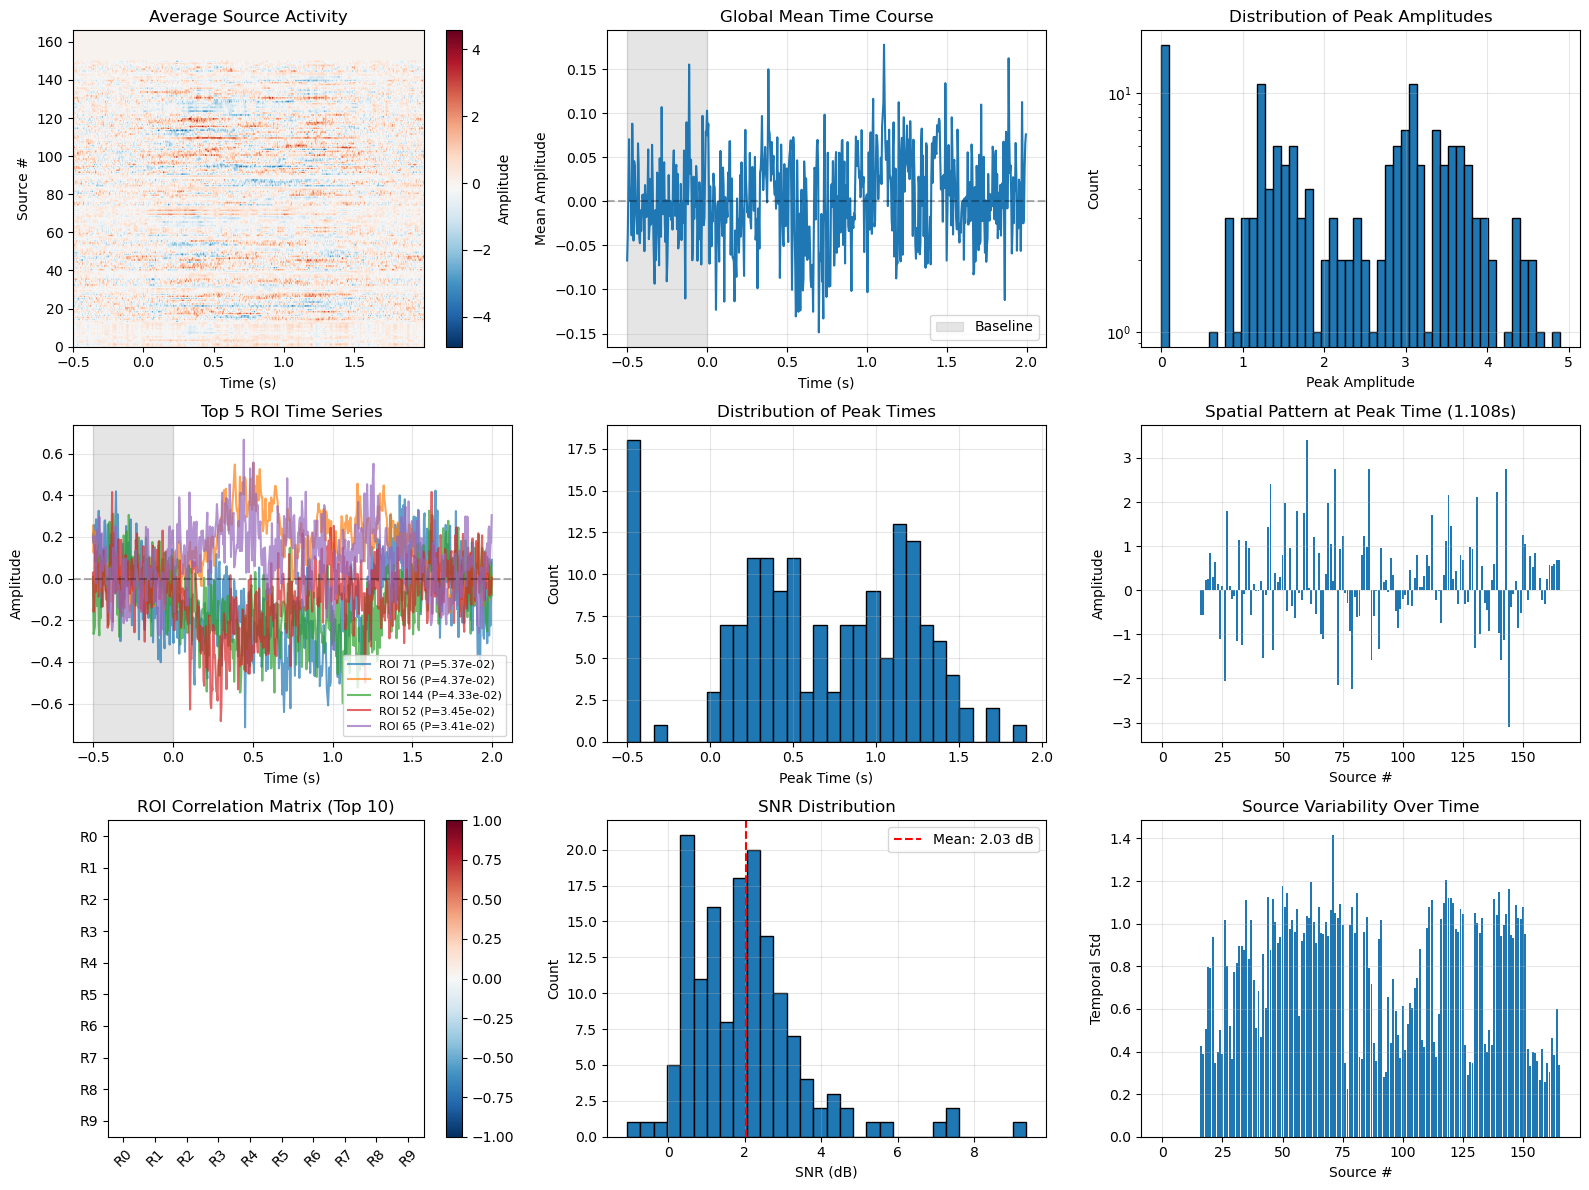

In [15]:
# 导入验证工具

from preprocessing.validate_source_reconstruction import (
    quick_validation,
    validate_source_reconstruction,
    plot_validation_results
)


# 快速检查
quick_validation(results, epochs_clean)

report = validate_source_reconstruction(results, epochs_clean, verbose=True)

# 生成完整的验证图表
fig = plot_validation_results(
    results, 
    epochs_clean, 
    save_dir='/workspace/shared/results/validation_plots'  # 保存图片的目录
)

In [16]:
# 1. 检查前向解
fwd = results['fwd']
leadfield = fwd['sol']['data']

print("前向解检查:")
print(f"  Leadfield 形状: {leadfield.shape}")
print(f"  Leadfield 范围: [{np.min(leadfield):.2e}, {np.max(leadfield):.2e}]")
print(f"  Leadfield 均值: {np.mean(leadfield):.2e}")
print(f"  Leadfield 标准差: {np.std(leadfield):.2e}")

# 2. 检查噪声协方差
inv = results['inv']
noise_cov = inv['noise_cov']

print("\n噪声协方差检查:")
print(f"  协方差形状: {noise_cov['data'].shape}")
print(f"  协方差范围: [{np.min(noise_cov['data']):.2e}, {np.max(noise_cov['data']):.2e}]")
print(f"  对角线均值: {np.mean(np.diag(noise_cov['data'])):.2e}")

# 3. 检查epochs数据范围
epochs_data = epochs_clean.get_data()
print("\nEpochs 数据检查:")
print(f"  数据形状: {epochs_data.shape}")
print(f"  数据范围: [{np.min(epochs_data):.2e}, {np.max(epochs_data):.2e}]")
print(f"  数据均值: {np.mean(epochs_data):.2e}")
print(f"  数据标准差: {np.std(epochs_data):.2e}")

# 4. 检查baseline
baseline_data = epochs_clean.copy().crop(tmin=-0.5, tmax=0).get_data()
print("\nBaseline 数据检查:")
print(f"  Baseline 形状: {baseline_data.shape}")
print(f"  Baseline 标准差: {np.std(baseline_data):.2e}")

前向解检查:
  Leadfield 形状: (280, 498)
  Leadfield 范围: [-3.63e+02, 5.98e+02]
  Leadfield 均值: 5.49e-01
  Leadfield 标准差: 3.13e+01

噪声协方差检查:
  协方差形状: (280, 280)
  协方差范围: [-1.52e-08, 2.55e-08]
  对角线均值: 4.33e-09

Epochs 数据检查:
  数据形状: (47, 280, 625)
  数据范围: [-4.05e-04, 4.56e-04]
  数据均值: -2.89e-22
  数据标准差: 6.59e-05

Baseline 数据检查:
  Baseline 形状: (47, 280, 126)
  Baseline 标准差: 6.58e-05


In [33]:
# 测试不同的 lambda2 值，复用上面筛选出的 epoch
lambda2_values = [1.0/1.0, 1.0/3.0, 1.0/9.0, 1.0/30.0]

for lambda2 in lambda2_values:
    print(f"
测试 lambda2 = {lambda2:.4f} (SNR = {1.0/np.sqrt(lambda2):.2f})")

    results_test = run_source_reconstruction_pipeline(
        epochs=epochs_clean,
        headmodel_file='/workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat',
        atlas_dir='/workspace/shared/data/raw/AAL3v2_for_SPM12/AAL3',
        trans_file=OUT_TRANS,
        method='sLORETA',
        lambda2=lambda2,
        noise_cov_method='auto',
        noise_cov_reg=0.1,
        epoch_indices=epoch_subset_indices,
        n_jobs=2
    )

    stc_data = results_test['stc'].data
    print(f"  数据范围: [{np.min(stc_data):.2e}, {np.max(stc_data):.2e}]")
    print(f"  数据标准差: {np.std(stc_data):.2e}")


2025-10-27 12:51:53,888 - preprocessing.source_reconstruction - INFO - 
2025-10-27 12:51:53,890 - preprocessing.source_reconstruction - INFO - SOURCE RECONSTRUCTION PIPELINE
2025-10-27 12:51:53,892 - preprocessing.source_reconstruction - INFO - ============================================================
2025-10-27 12:51:53,895 - preprocessing.source_reconstruction - INFO - 
[STEP 0] Checking electrode montage...
2025-10-27 12:51:53,918 - preprocessing.source_reconstruction - INFO - âœ“ Montage already set
2025-10-27 12:51:53,936 - preprocessing.source_reconstruction - INFO -   Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 280 channels>
2025-10-27 12:51:53,938 - preprocessing.source_reconstruction - INFO - 
[STEP 0.5] Checking EEG reference...
2025-10-27 12:51:53,939 - preprocessing.source_reconstruction - WARNING - Custom EEG reference detected. Converting to projection-based reference...
2025-10-27 12:51:53,940 - preprocessing.source_reconstruction - INFO -   This


测试 lambda2 = 1.0000 (SNR = 1.00)


2025-10-27 12:51:54,957 - preprocessing.source_reconstruction - INFO - ✓ EEG reference converted to projection-based average reference
2025-10-27 12:51:54,958 - preprocessing.source_reconstruction - INFO - 
[STEP 1] Loading head model...
2025-10-27 12:51:54,964 - preprocessing.source_reconstruction - INFO - Loading head model from: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
2025-10-27 12:52:12,836 - preprocessing.source_reconstruction - INFO - âœ“ Loaded as standard MAT file (v7 or lower)
2025-10-27 12:52:12,837 - preprocessing.source_reconstruction - INFO - Head model type: simbio
2025-10-27 12:52:12,838 - preprocessing.source_reconstruction - INFO - Unit: mm
2025-10-27 12:52:12,839 - preprocessing.source_reconstruction - INFO - Conductivity: [0.33 0.14 1.79 0.01 0.43]
2025-10-27 12:52:12,841 - preprocessing.source_reconstruction - INFO - Head model: {'type': 'simbio', 'unit': 'mm', 'conductivity': array([0.33, 0.14, 1.79, 0.01, 0.43]), 'tissue_labels': array([

  数据范围: [-4.21e+00, 4.45e+00]
  数据标准差: 7.10e-01

测试 lambda2 = 0.3333 (SNR = 1.73)


2025-10-27 12:52:28,033 - preprocessing.source_reconstruction - INFO - ✓ EEG reference converted to projection-based average reference
2025-10-27 12:52:28,035 - preprocessing.source_reconstruction - INFO - 
[STEP 1] Loading head model...
2025-10-27 12:52:28,040 - preprocessing.source_reconstruction - INFO - Loading head model from: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
2025-10-27 12:52:40,098 - preprocessing.source_reconstruction - INFO - âœ“ Loaded as standard MAT file (v7 or lower)
2025-10-27 12:52:40,099 - preprocessing.source_reconstruction - INFO - Head model type: simbio
2025-10-27 12:52:40,099 - preprocessing.source_reconstruction - INFO - Unit: mm
2025-10-27 12:52:40,100 - preprocessing.source_reconstruction - INFO - Conductivity: [0.33 0.14 1.79 0.01 0.43]
2025-10-27 12:52:40,101 - preprocessing.source_reconstruction - INFO - Head model: {'type': 'simbio', 'unit': 'mm', 'conductivity': array([0.33, 0.14, 1.79, 0.01, 0.43]), 'tissue_labels': array([

  数据范围: [-4.21e+00, 4.45e+00]
  数据标准差: 7.00e-01

测试 lambda2 = 0.1111 (SNR = 3.00)


2025-10-27 12:52:51,215 - preprocessing.source_reconstruction - INFO - ✓ EEG reference converted to projection-based average reference
2025-10-27 12:52:51,216 - preprocessing.source_reconstruction - INFO - 
[STEP 1] Loading head model...
2025-10-27 12:52:51,217 - preprocessing.source_reconstruction - INFO - Loading head model from: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
2025-10-27 12:53:04,270 - preprocessing.source_reconstruction - INFO - âœ“ Loaded as standard MAT file (v7 or lower)
2025-10-27 12:53:04,272 - preprocessing.source_reconstruction - INFO - Head model type: simbio
2025-10-27 12:53:04,273 - preprocessing.source_reconstruction - INFO - Unit: mm
2025-10-27 12:53:04,274 - preprocessing.source_reconstruction - INFO - Conductivity: [0.33 0.14 1.79 0.01 0.43]
2025-10-27 12:53:04,276 - preprocessing.source_reconstruction - INFO - Head model: {'type': 'simbio', 'unit': 'mm', 'conductivity': array([0.33, 0.14, 1.79, 0.01, 0.43]), 'tissue_labels': array([

  数据范围: [-4.21e+00, 4.45e+00]
  数据标准差: 6.98e-01

测试 lambda2 = 0.0333 (SNR = 5.48)


2025-10-27 12:53:15,906 - preprocessing.source_reconstruction - INFO - ✓ EEG reference converted to projection-based average reference
2025-10-27 12:53:15,909 - preprocessing.source_reconstruction - INFO - 
[STEP 1] Loading head model...
2025-10-27 12:53:15,910 - preprocessing.source_reconstruction - INFO - Loading head model from: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
2025-10-27 12:53:29,828 - preprocessing.source_reconstruction - INFO - âœ“ Loaded as standard MAT file (v7 or lower)
2025-10-27 12:53:29,830 - preprocessing.source_reconstruction - INFO - Head model type: simbio
2025-10-27 12:53:29,832 - preprocessing.source_reconstruction - INFO - Unit: mm
2025-10-27 12:53:29,833 - preprocessing.source_reconstruction - INFO - Conductivity: [0.33 0.14 1.79 0.01 0.43]
2025-10-27 12:53:29,836 - preprocessing.source_reconstruction - INFO - Head model: {'type': 'simbio', 'unit': 'mm', 'conductivity': array([0.33, 0.14, 1.79, 0.01, 0.43]), 'tissue_labels': array([

  数据范围: [-4.21e+00, 4.45e+00]
  数据标准差: 6.96e-01


In [34]:
"""
源重建诊断工具
=================

全面检查EEG数据、头模型、电极位置和坐标系统对齐问题

Author: Claude
Date: 2025-10-27
"""

import numpy as np
import mne
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def diagnose_source_reconstruction(
    epochs,
    headmodel_file,
    atlas_dir,
    output_dir='/home/claude/diagnostics'
):
    """
    全面诊断源重建问题
    
    Parameters
    ----------
    epochs : mne.Epochs
        预处理后的epochs数据
    headmodel_file : str
        头模型文件路径
    atlas_dir : str
        图谱目录
    output_dir : str
        输出目录
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    print("\n" + "="*70)
    print("源重建诊断工具 - 详细检查")
    print("="*70)
    
    # ========================================
    # 1. 检查Epochs基本信息
    # ========================================
    print("\n[1] 检查Epochs数据...")
    print(f"  - 通道数: {len(epochs.ch_names)}")
    print(f"  - Epochs数: {len(epochs)}")
    print(f"  - 采样率: {epochs.info['sfreq']} Hz")
    print(f"  - 时间窗口: [{epochs.times[0]:.3f}, {epochs.times[-1]:.3f}] s")
    
    # 检查数据质量
    data = epochs.get_data()
    print(f"\n  数据统计:")
    print(f"  - 形状: {data.shape}")
    print(f"  - 范围: [{np.min(data):.6e}, {np.max(data):.6e}]")
    print(f"  - 均值: {np.mean(data):.6e}")
    print(f"  - 标准差: {np.std(data):.6e}")
    
    # 检查是否有NaN或Inf
    has_nan = np.any(np.isnan(data))
    has_inf = np.any(np.isinf(data))
    if has_nan or has_inf:
        print(f"  ⚠️  警告: 数据包含 NaN={has_nan}, Inf={has_inf}")
    else:
        print(f"  ✓ 数据无NaN/Inf")
    
    # ========================================
    # 2. 检查电极位置和Montage
    # ========================================
    print("\n[2] 检查电极位置...")
    montage = epochs.info.get_montage()
    
    if montage is None:
        print("  ❌ 没有找到montage!")
        print("  → 建议: 设置standard_1020 montage")
        return
    
    print(f"  ✓ Montage已设置: {montage}")
    
    # 获取电极位置
    pos = montage.get_positions()
    ch_pos = pos['ch_pos']
    
    if len(ch_pos) == 0:
        print("  ❌ Montage中没有电极位置!")
        return
    
    print(f"  - 电极数量: {len(ch_pos)}")
    
    # 检查电极坐标范围
    positions = np.array(list(ch_pos.values()))
    print(f"\n  电极坐标统计 (单位: m):")
    print(f"  - X范围: [{positions[:, 0].min():.4f}, {positions[:, 0].max():.4f}]")
    print(f"  - Y范围: [{positions[:, 1].min():.4f}, {positions[:, 1].max():.4f}]")
    print(f"  - Z范围: [{positions[:, 2].min():.4f}, {positions[:, 2].max():.4f}]")
    print(f"  - 中心: [{positions[:, 0].mean():.4f}, {positions[:, 1].mean():.4f}, {positions[:, 2].mean():.4f}]")
    
    # 检查坐标系统
    coord_frame = epochs.info['dig'][0].get('coord_frame', None) if epochs.info['dig'] else None
    print(f"  - 坐标系: {coord_frame}")
    
    # 可视化电极位置
    fig = plt.figure(figsize=(15, 5))
    
    # 3D视图
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=50)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('电极位置 (3D)')
    
    # 顶视图
    ax2 = fig.add_subplot(132)
    ax2.scatter(positions[:, 0], positions[:, 1], c='blue', s=50)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('电极位置 (顶视图)')
    ax2.axis('equal')
    ax2.grid(True)
    
    # 侧视图
    ax3 = fig.add_subplot(133)
    ax3.scatter(positions[:, 1], positions[:, 2], c='blue', s=50)
    ax3.set_xlabel('Y (m)')
    ax3.set_ylabel('Z (m)')
    ax3.set_title('电极位置 (侧视图)')
    ax3.axis('equal')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'electrode_positions.png', dpi=150)
    print(f"\n  ✓ 电极位置图已保存: {output_dir / 'electrode_positions.png'}")
    plt.close()
    
    # ========================================
    # 3. 检查头模型
    # ========================================
    print("\n[3] 检查头模型...")
    try:
        headmodel_data = loadmat(headmodel_file, simplify_cells=True)
        headmodel = headmodel_data.get('headmodel', headmodel_data)
        
        # 提取网格信息
        if 'pos' in headmodel:
            head_pos = np.array(headmodel['pos'])
            print(f"  ✓ 头模型网格点数: {len(head_pos)}")
            
            # 检查单位
            unit = headmodel.get('unit', 'unknown')
            print(f"  - 单位: {unit}")
            
            # 转换为米（如果是mm）
            if unit == 'mm':
                head_pos_m = head_pos / 1000.0
                print(f"  - 转换后单位: m")
            else:
                head_pos_m = head_pos
            
            print(f"\n  头模型坐标统计:")
            print(f"  - X范围: [{head_pos_m[:, 0].min():.4f}, {head_pos_m[:, 0].max():.4f}] m")
            print(f"  - Y范围: [{head_pos_m[:, 1].min():.4f}, {head_pos_m[:, 1].max():.4f}] m")
            print(f"  - Z范围: [{head_pos_m[:, 2].min():.4f}, {head_pos_m[:, 2].max():.4f}] m")
            print(f"  - 中心: [{head_pos_m[:, 0].mean():.4f}, {head_pos_m[:, 1].mean():.4f}, {head_pos_m[:, 2].mean():.4f}] m")
            
            # 对比电极和头模型的坐标范围
            print(f"\n  [关键检查] 坐标系对齐检查:")
            print(f"  - 电极中心: [{positions[:, 0].mean():.4f}, {positions[:, 1].mean():.4f}, {positions[:, 2].mean():.4f}] m")
            print(f"  - 头模型中心: [{head_pos_m[:, 0].mean():.4f}, {head_pos_m[:, 1].mean():.4f}, {head_pos_m[:, 2].mean():.4f}] m")
            
            # 计算距离
            center_distance = np.linalg.norm(
                positions.mean(axis=0) - head_pos_m.mean(axis=0)
            )
            print(f"  - 中心距离: {center_distance:.4f} m")
            
            if center_distance > 0.1:  # 10cm
                print(f"  ⚠️  警告: 电极和头模型中心距离过大 ({center_distance:.2f} m)!")
                print(f"     这可能表示坐标系统不匹配!")
            else:
                print(f"  ✓ 中心距离合理")
                
        else:
            print("  ⚠️  头模型中未找到'pos'字段")
            
    except Exception as e:
        print(f"  ❌ 加载头模型失败: {e}")
    
    # ========================================
    # 4. 检查噪声协方差
    # ========================================
    print("\n[4] 检查噪声协方差...")
    
    # 计算噪声协方差
    try:
        noise_cov = mne.compute_covariance(
            epochs,
            tmin=None,
            tmax=0,
            method='empirical',
            verbose=False
        )
        
        print(f"  ✓ 噪声协方差计算成功")
        print(f"  - 矩阵形状: {noise_cov.data.shape}")
        print(f"  - 范围: [{noise_cov.data.min():.6e}, {noise_cov.data.max():.6e}]")
        print(f"  - 对角线均值: {np.diag(noise_cov.data).mean():.6e}")
        
        # 检查是否有NaN或Inf
        has_nan = np.any(np.isnan(noise_cov.data))
        has_inf = np.any(np.isinf(noise_cov.data))
        if has_nan or has_inf:
            print(f"  ❌ 噪声协方差包含 NaN={has_nan}, Inf={has_inf}")
        else:
            print(f"  ✓ 噪声协方差无NaN/Inf")
        
        # 检查是否过小
        diag_mean = np.diag(noise_cov.data).mean()
        if diag_mean < 1e-12:
            print(f"  ⚠️  警告: 噪声协方差对角线均值非常小 ({diag_mean:.6e})")
            print(f"     这可能导致数值不稳定!")
            
            # 建议正则化
            print(f"\n  建议:")
            print(f"  1. 使用正则化噪声协方差: reg=0.1")
            print(f"  2. 或使用全时间窗口计算协方差")
            
    except Exception as e:
        print(f"  ❌ 计算噪声协方差失败: {e}")
    
    # ========================================
    # 5. 尝试简化的前向解
    # ========================================
    print("\n[5] 测试简化的前向解...")
    
    try:
        # 创建简单的源空间（单个源）
        src_test = mne.setup_volume_source_space(
            pos=50.0,
            sphere=(0., 0., 0., 0.09),  # 9cm半径
            verbose=False
        )
        
        print(f"  ✓ 测试源空间创建成功: {src_test[0]['nuse']} 个源")
        
        # 创建球形头模型
        sphere = mne.make_sphere_model(
            r0='auto',
            head_radius='auto',
            info=epochs.info,
            verbose=False
        )
        
        print(f"  ✓ 球形头模型创建成功")
        
        # 创建identity transform
        trans = mne.Transform(
            fro='head',
            to='mri',
            trans=np.eye(4)
        )
        
        print(f"  ✓ Identity transform创建成功")
        
        # 计算前向解
        fwd_test = mne.make_forward_solution(
            epochs.info,
            trans=trans,
            src=src_test,
            bem=sphere,
            mindist=5.0 / 1000.0,
            n_jobs=1,
            verbose=False
        )
        
        print(f"  ✓ 前向解计算成功!")
        print(f"  - Leadfield形状: {fwd_test['sol']['data'].shape}")
        print(f"  - 源数: {fwd_test['nsource']}")
        print(f"  - 通道数: {fwd_test['nchan']}")
        
        leadfield = fwd_test['sol']['data']
        print(f"  - Leadfield范围: [{leadfield.min():.6e}, {leadfield.max():.6e}]")
        
        # 检查leadfield
        has_nan = np.any(np.isnan(leadfield))
        has_inf = np.any(np.isinf(leadfield))
        if has_nan or has_inf:
            print(f"  ❌ Leadfield包含 NaN={has_nan}, Inf={has_inf}")
        else:
            print(f"  ✓ Leadfield无NaN/Inf")
        
        # 尝试创建逆算子
        print(f"\n  尝试创建逆算子...")
        try:
            inv_test = mne.minimum_norm.make_inverse_operator(
                epochs.info,
                fwd_test,
                noise_cov,
                loose=0.2,
                depth=0.8,
                verbose=False
            )
            print(f"  ✓ 逆算子创建成功!")
            
        except Exception as e:
            print(f"  ❌ 创建逆算子失败: {e}")
            print(f"\n  这是关键错误! 可能的原因:")
            print(f"  1. 噪声协方差数值太小或不稳定")
            print(f"  2. 电极位置和源空间坐标系不匹配")
            print(f"  3. Forward solution中存在数值问题")
            
    except Exception as e:
        print(f"  ❌ 前向解测试失败: {e}")
    
    # ========================================
    # 总结
    # ========================================
    print("\n" + "="*70)
    print("诊断总结")
    print("="*70)
    
    print("\n建议检查顺序:")
    print("1. 确认电极montage是否正确设置 (standard_1020)")
    print("2. 检查电极位置和头模型的坐标范围是否匹配")
    print("3. 如果中心距离>10cm，说明坐标系统不匹配")
    print("4. 检查噪声协方差是否过小或包含NaN/Inf")
    print("5. 尝试使用正则化: reg=0.1")
    
    print("\n可能的解决方案:")
    print("A. 如果是坐标系问题:")
    print("   - 检查头模型单位 (mm vs m)")
    print("   - 可能需要手动配准 (coregistration)")
    print("   - 或使用MNE标准模板代替")
    print("\nB. 如果是数值问题:")
    print("   - 增加noise_cov正则化")
    print("   - 使用全时间窗口计算协方差")
    print("   - 标准化数据幅度")
    
    print("\n" + "="*70)




In [17]:
import numpy as np

# 1. 获取电极位置（digitization points）
dig = epochs_clean.info['dig']
pos = np.array([d['r'] for d in dig if d['kind'] == 1])  # EEG点 kind=1

print("EEG坐标范围 (m):")
print("  X:", pos[:, 0].min(), "→", pos[:, 0].max())
print("  Y:", pos[:, 1].min(), "→", pos[:, 1].max())
print("  Z:", pos[:, 2].min(), "→", pos[:, 2].max())



EEG坐标范围 (m):
  X: -0.07496 → 0.07804
  Y: -0.00251 → 0.09902
  Z: -0.13732 → -0.11332


In [ ]:
import numpy as np
import mne
from scipy.io import loadmat
from pathlib import Path

# ==== 0) 基本输入 ====
ft_headmodel_path = Path("/workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat")

def _get_eeg_xyz_from_info(info):
    """从 raw.info['dig'] 提取 EEG 电极 3D 坐标（米）"""
    if info is None or info.get('dig') is None:
        return np.empty((0,3))
    pts = [d['r'] for d in info['dig'] if d['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG]
    return np.array(pts) if len(pts) else np.empty((0,3))

def describe_range(name, xyz):
    if xyz.size == 0:
        print(f"[{name}] 无坐标点")
        return
    mins = xyz.min(axis=0)
    maxs = xyz.max(axis=0)
    print(f"[{name}] 点数: {len(xyz)}")
    print(f"[{name}] X范围(m): {mins[0]:.6f} → {maxs[0]:.6f}")
    print(f"[{name}] Y范围(m): {mins[1]:.6f} → {maxs[1]:.6f}")
    print(f"[{name}] Z范围(m): {mins[2]:.6f} → {maxs[2]:.6f}")

def check_flat_axis(xyz, eps=1e-9):
    if xyz.size == 0:
        return []
    flat = []
    for i, ax in enumerate("XYZ"):
        if np.all(np.isclose(xyz[:, i], xyz[0, i], atol=eps)):
            flat.append(ax)
    return flat

def scale_from_unit_str(unit_str):
    unit_str = (unit_str or "").strip().lower()
    if unit_str in ("m", "meter", "metre"):
        return 1.0, "m"
    if unit_str in ("cm", "centimeter", "centimetre"):
        return 0.01, "cm"
    if unit_str in ("mm", "millimeter", "millimetre"):
        return 0.001, "mm"
    # 未知：多数 FieldTrip 模型也是米
    return 1.0, unit_str or "unknown"

# ==== 1) EEG: 从当前 raw 取坐标 ====
# 若你已有 raw 变量，注释掉下一行；否则示例读取（请替换为你的数据）
# raw = mne.io.read_raw_fif("eeg_raw.fif", preload=False)

try:
    eeg_xyz = _get_eeg_xyz_from_info(epochs_clean.info)
except NameError:
    eeg_xyz = np.empty((0,3))
    print("提示：未找到 raw 变量；仅执行头模型检查。若要检查EEG坐标，请先加载 raw 并确保包含 dig。")

if eeg_xyz.size:
    print("\n=== EEG 坐标检查 ===")
    describe_range("EEG", eeg_xyz)
    flat_axes = check_flat_axis(eeg_xyz)
    if flat_axes:
        print(f"⚠️ 发现以下坐标轴恒定（可能是2D坐标/单位或配准问题）：{', '.join(flat_axes)}")
    # 经验范围检查
    ok_range = np.all((eeg_xyz >= -0.15) & (eeg_xyz <= 0.15))
    if not ok_range:
        print("⚠️ EEG 坐标超出 ±0.15 m，可能是单位错误（例如 mm/cm 未换算为 m）。")
else:
    print("未检测到 EEG 坐标点（dig）。")

# ==== 2) FieldTrip 头模型检查 ====
print("\n=== FieldTrip 头模型检查 ===")
mat = loadmat(ft_headmodel_path, squeeze_me=True, struct_as_record=False)
# FieldTrip 常见为 mat['headmodel'] 结构体
headmodel = mat.get('headmodel', None)
if headmodel is None:
    raise RuntimeError("在 .mat 中未找到 'headmodel' 字段。请检查文件。")

# 读取字段：pos, unit, type（不同版本字段名可能略变）
pos = getattr(headmodel, 'pos', None)
unit = getattr(headmodel, 'unit', None)
hm_type = getattr(headmodel, 'type', None)
coordsys = getattr(headmodel, 'coordsys', None) if hasattr(headmodel, 'coordsys') else None

if isinstance(unit, np.ndarray):
    unit = str(unit)
if isinstance(hm_type, np.ndarray):
    hm_type = str(hm_type)
if isinstance(coordsys, np.ndarray):
    coordsys = str(coordsys)

scale, unit_in = scale_from_unit_str(unit)
print(f"headmodel.type    : {hm_type}")
print(f"headmodel.unit    : {unit_in}  (→ m 的缩放因子 = {scale})")
print(f"headmodel.coordsys: {coordsys}")

if pos is None:
    raise RuntimeError("headmodel 中无 pos 顶点坐标。")
pos = np.array(pos, dtype=float) * scale  # 统一换算为米
describe_range("HeadModel(pos, to meters)", pos)

# 经验范围检查
ok_range_hm = np.all((pos >= -0.2) & (pos <= 0.2))
if not ok_range_hm:
    print("⚠️ 头模型坐标超出 ±0.2 m，疑似单位/坐标系问题。")

# ==== 3) 粗对比 ====
if eeg_xyz.size:
    eeg_ctr = eeg_xyz.mean(axis=0)
    hm_ctr  = pos.mean(axis=0)
    delta = eeg_ctr - hm_ctr
    print("\n=== EEG vs HeadModel 粗对比 ===")
    print(f"两者质心差 (m): ΔX={delta[0]:.4f}, ΔY={delta[1]:.4f}, ΔZ={delta[2]:.4f}")
    # 经验阈值：质心差 > 5 cm 需要警惕（未共配准或坐标系不同）
    if np.linalg.norm(delta) > 0.05:
        print("⚠️ 两者质心差大于 5 cm：尚未共配准（需要 trans）或坐标框架不同。")
    # Z 是否一致性检查
    if np.allclose(eeg_xyz[:,2], 0, atol=1e-9):
        print("❗ EEG 的 Z 坐标全为 0：这是 2D 平面坐标，无法用于 forward。请换用带 3D 的 montage/dig。")

print("\n检查完成。")



=== EEG 坐标检查 ===
[EEG] 点数: 281
[EEG] X范围(m): -0.088149 → 0.085911
[EEG] Y范围(m): -0.086077 → 0.116390
[EEG] Z范围(m): -0.056304 → 0.151643
⚠️ EEG 坐标超出 ±0.15 m，可能是单位错误（例如 mm/cm 未换算为 m）。

=== FieldTrip 头模型检查 ===
headmodel.type    : simbio
headmodel.unit    : mm  (→ m 的缩放因子 = 0.001)
headmodel.coordsys: None
[HeadModel(pos, to meters)] 点数: 6009072
[HeadModel(pos, to meters)] X范围(m): -0.090095 → 0.088492
[HeadModel(pos, to meters)] Y范围(m): -0.173124 → 0.116524
[HeadModel(pos, to meters)] Z范围(m): -0.170705 → 0.097319

=== EEG vs HeadModel 粗对比 ===
两者质心差 (m): ΔX=0.0004, ΔY=0.0284, ΔZ=0.0934
⚠️ 两者质心差大于 5 cm：尚未共配准（需要 trans）或坐标框架不同。

检查完成。


: 

In [35]:
diagnose_source_reconstruction(
    epochs=epochs_clean,
    headmodel_file='/workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat',
    atlas_dir='/workspace/shared/data/raw/AAL3v2_for_SPM12/AAL3'
)


源重建诊断工具 - 详细检查

[1] 检查Epochs数据...
  - 通道数: 280
  - Epochs数: 40
  - 采样率: 250.0 Hz
  - 时间窗口: [-0.500, 1.996] s

  数据统计:
  - 形状: (40, 280, 625)
  - 范围: [-3.311030e-04, 3.345397e-04]
  - 均值: -3.927030e-10
  - 标准差: 6.460038e-05
  ✓ 数据无NaN/Inf

[2] 检查电极位置...
  ✓ Montage已设置: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 280 channels>
  - 电极数量: 280

  电极坐标统计 (单位: m):
  - X范围: [-0.0881, 0.0859]
  - Y范围: [-0.0861, 0.1164]
  - Z范围: [-0.0563, 0.1516]
  - 中心: [-0.0013, 0.0080, 0.0597]
  - 坐标系: 4 (FIFFV_COORD_HEAD)


/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 39030 (\N{CJK UNIFIED IDEOGRAPH-9876}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1151/2471748698.py:138: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAP


  ✓ 电极位置图已保存: /home/claude/diagnostics/electrode_positions.png

[3] 检查头模型...
  ✓ 头模型网格点数: 6009072
  - 单位: mm
  - 转换后单位: m

  头模型坐标统计:
  - X范围: [-0.0901, 0.0885] m
  - Y范围: [-0.1731, 0.1165] m
  - Z范围: [-0.1707, 0.0973] m
  - 中心: [-0.0017, -0.0203, -0.0334] m

  [关键检查] 坐标系对齐检查:
  - 电极中心: [-0.0013, 0.0080, 0.0597] m
  - 头模型中心: [-0.0017, -0.0203, -0.0334] m
  - 中心距离: 0.0973 m
  ✓ 中心距离合理

[4] 检查噪声协方差...
  ✓ 噪声协方差计算成功
  - 矩阵形状: (280, 280)
  - 范围: [-1.487630e-08, 2.522940e-08]
  - 对角线均值: 4.176120e-09
  ✓ 噪声协方差无NaN/Inf

[5] 测试简化的前向解...
  ✓ 测试源空间创建成功: 19 个源
  ✓ 球形头模型创建成功
  ✓ Identity transform创建成功
  ✓ 前向解计算成功!
  - Leadfield形状: (280, 57)
  - 源数: 19
  - 通道数: 280
  - Leadfield范围: [-3.516782e+02, 3.568452e+02]
  ✓ Leadfield无NaN/Inf

  尝试创建逆算子...


/tmp/ipykernel_1151/2471748698.py:302: RuntimeWarning: The largest eigenvalue of the 280-channel eeg covariance (rank=279) is over 10 orders of magnitude larger than the smallest (1.16e-06 > 1e10 * 5.82e-19), the resulting whitener will likely be unstable
  inv_test = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_1151/2471748698.py:302: RuntimeWarning: The largest eigenvalue of the 280-channel eeg covariance (rank=279) is over 10 orders of magnitude larger than the smallest (1.16e-06 > 1e10 * 5.82e-19), the resulting whitener will likely be unstable
  inv_test = mne.minimum_norm.make_inverse_operator(


  ❌ 创建逆算子失败: array must not contain infs or NaNs

  这是关键错误! 可能的原因:
  1. 噪声协方差数值太小或不稳定
  2. 电极位置和源空间坐标系不匹配
  3. Forward solution中存在数值问题

诊断总结

建议检查顺序:
1. 确认电极montage是否正确设置 (standard_1020)
2. 检查电极位置和头模型的坐标范围是否匹配
3. 如果中心距离>10cm，说明坐标系统不匹配
4. 检查噪声协方差是否过小或包含NaN/Inf
5. 尝试使用正则化: reg=0.1

可能的解决方案:
A. 如果是坐标系问题:
   - 检查头模型单位 (mm vs m)
   - 可能需要手动配准 (coregistration)
   - 或使用MNE标准模板代替

B. 如果是数值问题:
   - 增加noise_cov正则化
   - 使用全时间窗口计算协方差
   - 标准化数据幅度



In [ ]:
# 3.5 源空间重建（可选，需要MRI数据）
# 如果有个体MRI，可以进行源重建
use_source_reconstruction = False  # 设置为True以启用

if use_source_reconstruction:
    print("\n=== 源空间重建 ===")
    
    subjects_dir = '/path/to/freesurfer/subjects'
    subject_mri = 'fsaverage'  # 或个体受试者ID
    
    # 计算源空间
    source_info = eeg_prep.compute_source_space(
        eeg_raw_clean,
        subjects_dir=subjects_dir,
        subject=subject_mri,
        spacing='oct6'
    )
    
    # 计算逆解
    inverse_solution = eeg_prep.compute_inverse_operator(
        eeg_epochs,
        fwd=source_info['fwd'],
        method='dSPM'
    )
    
    # 提取ROI时间序列
    # 需要定义ROI标签
    # labels_dict = {'M1': m1_label, 'SMA': sma_label}
    # roi_timeseries = eeg_prep.extract_roi_timeseries(
    #     inverse_solution['stcs'],
    #     labels_dict,
    #     mode='mean'
    # )

print(eeg_prep.get_processing_summary())

## 4. LFP专用预处理

In [17]:
# 创建LFP预处理器
lfp_prep = LFPPreprocessor()

# 4.1 解析电极接触点
print("\n=== 解析电极接触点 ===")
electrode_info = lfp_prep.parse_electrode_contacts(lfp_raw_clean)

print(f"\n左侧电极: {electrode_info['left']}")
print(f"右侧电极: {electrode_info['right']}")

INFO:preprocessing.lfp_preprocessing:解析电极接触点信息...
INFO:preprocessing.lfp_preprocessing:✓ 左侧电极: 2 个接触点
INFO:preprocessing.lfp_preprocessing:✓ 右侧电极: 2 个接触点



=== 解析电极接触点 ===

左侧电极: ['LFP_L', 'STIM_L']
右侧电极: ['LFP_R', 'STIM_R']


In [18]:
# 4.2 去除刺激伪迹（如果有DBS刺激）
has_stimulation = False  # 如果有刺激，设置为True

if has_stimulation:
    print("\n=== 去除刺激伪迹 ===")
    
    # 提取刺激事件
    stim_events = None  # 需要从数据中提取
    
    lfp_raw_clean = lfp_prep.remove_stimulation_artifacts(
        lfp_raw_clean,
        stim_events=stim_events,
        method='template',
        window=(-0.005, 0.01),
        copy=False
    )

In [19]:
# 4.3 应用双极参考
print("\n=== 应用双极参考 ===")
lfp_raw_bipolar = lfp_prep.apply_bipolar_reference(
    lfp_raw_clean,
    copy=True  # 保留单极数据
)

INFO:preprocessing.lfp_preprocessing:✓ 已应用双极参考，生成 2 个双极通道



=== 应用双极参考 ===


In [20]:
# 4.4 增强信噪比
print("\n=== 增强信噪比 ===")
lfp_raw_enhanced = lfp_prep.enhance_snr(
    lfp_raw_bipolar,
    method='car',
    copy=True
)

INFO:preprocessing.lfp_preprocessing:✓ 已应用共平均参考(CAR)



=== 增强信噪比 ===


In [21]:
# 4.5 可选：小波去噪或平滑
use_wavelet_denoising = False  # 可选
use_smoothing = False  # 可选

if use_wavelet_denoising:
    print("\n=== 小波去噪 ===")
    lfp_raw_enhanced = lfp_prep.apply_wavelet_denoising(
        lfp_raw_enhanced,
        wavelet='db4',
        level=4,
        copy=False
    )

if use_smoothing:
    print("\n=== 平滑 ===")
    lfp_raw_enhanced = lfp_prep.apply_smoothing(
        lfp_raw_enhanced,
        window_length=11,
        polyorder=3,
        copy=False
    )

print(lfp_prep.get_processing_summary())

LFP处理步骤:
  1. parse_electrode_contacts
  2. apply_bipolar_reference
  3. enhance_snr_car



In [22]:
# 4.6 创建LFP epochs
print("\n=== 创建LFP epochs ===")

lfp_epochs = mne.Epochs(
    lfp_raw_enhanced,
    events,
    event_id,
    tmin=-0.5,
    tmax=1.5,
    baseline=(-0.2, 0),
    preload=True,
    verbose=False
)

print(f"保留 {len(lfp_epochs)} 个epochs")


=== 创建LFP epochs ===


ValueError: max() iterable argument is empty

## 5. 联合处理

In [ ]:
# 创建联合处理器
joint_prep = JointPreprocessor()

# 5.1 对齐时间窗口
print("\n=== 对齐时间窗口 ===")
eeg_aligned, lfp_aligned = joint_prep.align_time_windows(
    eeg_raw_clean,
    lfp_raw_enhanced,
    crop_to='shorter'
)

In [ ]:
# 5.2 同步epochs
print("\n=== 同步epochs ===")
eeg_epochs_sync, lfp_epochs_sync = joint_prep.synchronize_epochs(
    eeg_epochs,
    lfp_epochs,
    tolerance=0.001
)

In [ ]:
# 5.3 频段分解
print("\n=== 频段分解 ===")

# 定义感兴趣的频段
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 100)
}

# 提取EEG频段
eeg_bands = joint_prep.extract_frequency_bands(
    eeg_aligned,
    bands=freq_bands,
    method='filter'
)

# 提取LFP频段
lfp_bands = joint_prep.extract_frequency_bands(
    lfp_aligned,
    bands=freq_bands,
    method='filter'
)

In [ ]:
# 5.4 计算频段功率
print("\n=== 计算频段功率 ===")

eeg_band_power = joint_prep.compute_band_power(
    eeg_epochs_sync,
    bands=freq_bands,
    method='welch'
)

lfp_band_power = joint_prep.compute_band_power(
    lfp_epochs_sync,
    bands=freq_bands,
    method='welch'
)

# 显示频段功率形状
for band in freq_bands.keys():
    print(f"  EEG {band}: {eeg_band_power[band].shape}")
    print(f"  LFP {band}: {lfp_band_power[band].shape}")

In [ ]:
# 5.5 标准化
print("\n=== 标准化 ===")

# 标准化频段功率
for band in freq_bands.keys():
    eeg_band_power[band] = joint_prep.normalize_signals(
        eeg_band_power[band],
        method='zscore',
        axis=-1
    )
    
    lfp_band_power[band] = joint_prep.normalize_signals(
        lfp_band_power[band],
        method='zscore',
        axis=-1
    )

In [ ]:
# 5.6 准备连接性分析数据
print("\n=== 准备连接性分析数据 ===")

connectivity_data = joint_prep.prepare_connectivity_data(
    eeg_epochs_sync,
    lfp_epochs_sync
)

print(f"连接性数据形状: {connectivity_data['data'].shape}")
print(f"EEG通道数: {connectivity_data['n_eeg']}")
print(f"LFP通道数: {connectivity_data['n_lfp']}")

print(joint_prep.get_processing_summary())

## 6. 质量控制与保存

In [ ]:
# 创建质量控制器
output_dir = './qc_outputs'
qc = QualityControl(output_dir=output_dir)

# 6.1 绘制功率谱对比
print("\n=== 生成质量控制图 ===")

qc.plot_psd_comparison(
    eeg_raw_orig,
    eeg_raw_clean,
    save_path=f'{output_dir}/eeg_psd_comparison.png'
)

qc.plot_psd_comparison(
    lfp_raw_orig,
    lfp_raw_enhanced,
    save_path=f'{output_dir}/lfp_psd_comparison.png'
)

In [ ]:
# 6.2 绘制信号对比
qc.plot_signal_comparison(
    eeg_raw_orig,
    eeg_raw_clean,
    duration=5.0,
    channel_idx=0,
    save_path=f'{output_dir}/eeg_signal_comparison.png'
)

qc.plot_signal_comparison(
    lfp_raw_orig,
    lfp_raw_enhanced,
    duration=5.0,
    channel_idx=0,
    save_path=f'{output_dir}/lfp_signal_comparison.png'
)

In [ ]:
# 6.3 绘制epochs质量
qc.plot_epochs_quality(
    eeg_epochs_sync,
    save_path=f'{output_dir}/eeg_epochs_quality.png'
)

qc.plot_epochs_quality(
    lfp_epochs_sync,
    save_path=f'{output_dir}/lfp_epochs_quality.png'
)

In [ ]:
# 6.4 绘制频段分解
qc.plot_frequency_bands(
    eeg_bands,
    channel_idx=0,
    duration=5.0,
    save_path=f'{output_dir}/eeg_frequency_bands.png'
)

qc.plot_frequency_bands(
    lfp_bands,
    channel_idx=0,
    duration=5.0,
    save_path=f'{output_dir}/lfp_frequency_bands.png'
)

In [ ]:
# 6.5 计算信噪比
print("\n=== 计算信噪比 ===")

eeg_snr = qc.compute_snr(eeg_raw_clean)
lfp_snr = qc.compute_snr(lfp_raw_enhanced)

In [ ]:
# 6.6 生成质量报告
print("\n=== 生成质量报告 ===")

# 收集所有处理步骤
all_processing_steps = (
    eeg_cleaner.processing_history +
    eeg_prep.processing_log +
    lfp_cleaner.processing_history +
    lfp_prep.processing_log +
    joint_prep.processing_log
)

# 收集质量指标
quality_metrics = {
    'n_eeg_epochs': len(eeg_epochs_sync),
    'n_lfp_epochs': len(lfp_epochs_sync),
    'eeg_mean_snr': np.mean(list(eeg_snr.values())),
    'lfp_mean_snr': np.mean(list(lfp_snr.values())),
    'n_bad_channels': len(bad_channels)
}

# 生成报告
qc_report = qc.generate_qc_report(
    preprocessing_steps=all_processing_steps,
    metrics=quality_metrics,
    save_path=f'{output_dir}/quality_control_report.txt'
)

print(qc_report)

In [ ]:
# 6.7 保存为BIDS derivatives
print("\n=== 保存BIDS derivatives ===")

saver = BIDSDerivativesSaver(
    bids_root=bids_root,
    derivatives_name='preprocessing'
)

# 保存预处理后的原始数据
saver.save_preprocessed_raw(
    eeg_raw_clean,
    subject=subject,
    session=session,
    task=task,
    datatype='eeg',
    suffix='eeg',
    run=run,
    description='clean'
)

saver.save_preprocessed_raw(
    lfp_raw_enhanced,
    subject=subject,
    session=session,
    task=task,
    datatype='ieeg',
    suffix='ieeg',
    run=run,
    description='clean'
)

# 保存epochs
saver.save_epochs(
    eeg_epochs_sync,
    subject=subject,
    session=session,
    task=task,
    datatype='eeg',
    run=run,
    description='clean'
)

saver.save_epochs(
    lfp_epochs_sync,
    subject=subject,
    session=session,
    task=task,
    datatype='ieeg',
    run=run,
    description='clean'
)

# 保存处理元数据
processing_info = {
    'preprocessing_steps': all_processing_steps,
    'quality_metrics': quality_metrics,
    'bad_channels': bad_channels,
    'artifact_components': artifact_comps['all'],
    'frequency_bands': freq_bands
}

saver.save_derivative_metadata(
    processing_info,
    subject=subject,
    session=session
)

print("\n✓ 预处理完成！所有结果已保存。")

## 总结

预处理流程已完成，包括：

1. ✓ 数据验证与检查
2. ✓ 通用清洗（去趋势、滤波、重采样）
3. ✓ EEG预处理（坏导插值、重参考、ICA、分段）
4. ✓ LFP预处理（伪迹去除、双极参考、增强SNR）
5. ✓ 联合处理（时间对齐、频段分解、标准化）
6. ✓ 质量控制与保存

下一步可以进行：
- 跨通道连接性分析
- 时频分析
- 相位-振幅耦合（PAC）
- 功能性连接
- 统计分析